# 作业 2：图像阐述 Dino Fun World

Dino Fun World 管理员对你之前的工作印象深刻，想要你创建一些图表，以供他们下一次向高层管理人员汇报工作的演示中使用。用于此作业的数据与用于上一个作业的数据相同。

### 提供的数据库

游乐园管理部门提供的数据库格式化可供任何 SQL 数据库读取。课程员工推荐 使用sqlite3 库。该数据库包含三个表格，分别为“登记”、“景点”和“序列”。每个表中所含的信息如下所示：

`登记`：

   - 说明：游乐园当天所有游客的登记数据。该数据包括两类登记数据，即推测登记数据和实际登记数据。

   - 字段：游客编号 (visitorID)、时间戳 (timestamp)、景点 (attraction)、持续时间 (duration)、类型 (type)
   
`景点`：

   - 游乐园景点包括相应的景点编号、名称、区域、类别和类型。区域包括 VAST 挑战地图，如过山车场区、冻原之地等。类别包括惊险飞车、儿童碰碰车等。类型包括户外过山车、其他游乐项目、旋转木马等

   - 字段：景点编号 (AttractionID)、名称 (Name)、区域 (Region)、类别 (Category), 类型 (type)
   
`序列`：

  - 游客登记序列。这些序列列出每五分钟进入游乐场的每个游客位置。如果游客尚未进入游乐场，则该时间段内序列的值为 0。如果游客已进入游乐场，则序列列出游客最近登记的景点，或游客离开游乐场前最后登记的景点。

  - 字段：游客编号 (visitorID)、序列 (sequence)
  
数据库文件名称为“dinofunworld.db”，可以在 Jupyter Notebook 环境（即 readonly/dinofunworld.db）中的只读目录中找到。

### 作业

1: 游乐园的管理员希望你帮助他们了解游客游览游乐园的不同路线以及他们参加的不同游乐项目。在此任务中，他们随机选择了 5 名游客，并希望你分析这些游客的登记序列。现在，他们希望你针对这 5 名游客构造一个距离矩阵。五名游客的编号为：165316、1835254、296394、404385 和 448990。

2: 游乐园的管理员想要了解每个游乐项目的参加动态（请注意，并非所有景点都是游乐项目）。他们希望看到一张图(例如平行坐标图)上看到每个游乐项目的最小（非零）参入量、一整天的平均参入量以及每个游乐项目的最大参入量。

3: 除了 平行坐标图，管理员希望看到描述每个游乐项目的最小、平均和最大参入量的散点图矩阵，如上所述。


#### 管理注意事项

为了让你的答案可以正确登记在该系统中，你必须将你的答案代码填写在每个问题对应的单元格内。此外，你的作业必须连同该单元格区域显示的代码一同提交。该显示区域应该仅仅包含你为该问题给出的答案，除此之外别无其它信息，要么就是没有正确选择答案。待评分的每个单元格在开头有几行评语。这些行极其重要，不得修改或删除。

In [54]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pandas.plotting import parallel_coordinates, scatter_matrix
conn = sqlite3.connect('dinofunworld.db')
c = conn.cursor()

In [24]:
# 1: 游乐园的管理员希望你帮助他们了解游客游览游乐园的不同路线以及他们参加的不同游乐项目。
# 在此任务中，他们随机选择了 5 名游客，并希望你分析这些游客的登记序列。
# 现在，他们希望你针对这 5 名游客构造一个距离矩阵。五名游客的编号为：165316、1835254、296394、404385 和 448990。


# 分析：创建一个距离矩阵，用于 5 个指定访客的 sequences 的聚类。 
# 定义距离函数：sequence存储的是景点的id，题目未提供各景点的物理距离，将所有景点之间的距离视为1（单位量）。 
# 计算每个游客各sequence检查点相对其他用户对应点的距离并统计。
c.execute("SELECT visitorID, sequence FROM sequences where visitorID IN (165316, 1835254, 296394, 404385, 448990);")
sequences = c.fetchall()
sequences_frame = pd.DataFrame.from_records(sequences, columns=['visitorID', 'sequence'])
sequences_frame['sequence_array'] = sequences_frame['sequence'].apply(lambda s: s.split("-"))

distance_wrapper_dict = {}
# 分别计算5个visitor与其他visitor相对距离
for i in range(5):
#     计算每个visitor与其他visitor的距离，距离是相对的，计算过A与B的距离，就不必再计算B与A的距离
    for j in range(i+1, 5):
#         计算visitor i与 visitor j的距离,
        distance_i_j = sum(sequence_i != sequence_j for sequence_i, sequence_j in zip(sequences_frame['sequence_array'][i], sequences_frame['sequence_array'][j]))
        id_i = sequences_frame['visitorID'][i]
        id_j = sequences_frame['visitorID'][j]
#         获取用于存放visitor相对其他visitor距离的字典
        visitor_distance_dict_i = distance_wrapper_dict.get(id_i, {})
#         visitor_i相对visitor_j的距离
        visitor_distance_dict_i[id_j] = distance_i_j
#     更新或创建visitor i相对其他visitor距离的字典
        distance_wrapper_dict[id_i] = visitor_distance_dict_i
#     距离是相对的，记录下visitor_j 相对visitor_i的距离
        visitor_distance_dict_j = distance_wrapper_dict.get(id_j, {})
        visitor_distance_dict_j[id_i] = distance_i_j
        distance_wrapper_dict[id_j] = visitor_distance_dict_j
print(distance_wrapper_dict)

{165316: {296394: 318, 404385: 329, 448990: 318, 1835254: 336}, 296394: {165316: 318, 404385: 303, 448990: 0, 1835254: 282}, 404385: {165316: 329, 296394: 303, 448990: 303, 1835254: 298}, 448990: {165316: 318, 296394: 0, 404385: 303, 1835254: 282}, 1835254: {165316: 336, 296394: 282, 404385: 298, 448990: 282}}


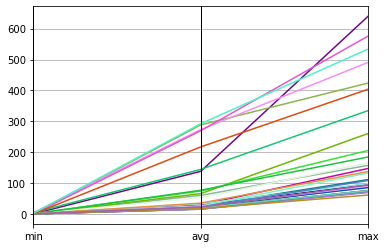

                         ride  min         avg  max
0      Wrightiraptor Mountain    1   60.889780  158
1          Galactosaurus Rage    1   66.577551  261
2          Auvilotops Express    1  138.728745  640
3                  TerrorSaur    2  288.690909  424
4           Wendisaurus Chase    5  273.585366  491
5        Keimosaurus Big Spin    2   74.935354  206
6                    Firefall    1  270.036145  576
7                   Atmosfear    5  144.986056  335
8                  North Line    1   53.196721  166
9             Jeredactyl Jump    1   26.783262  112
10            Sauroma Bumpers    1   30.146930  148
11       Flying TyrAndrienkos    1   24.585313   98
12       Cyndisaurus Asteroid    1   16.873303   72
13                 Beelzebufo    1   18.239726   93
14       Enchanted Toadstools    1   16.357616   77
15                Stegocycles    1   17.145740   76
16             Blue Iguanodon    1   17.110360   73
17         Wild Jungle Cruise    1   19.439909   90
18          

In [52]:
# 2: 游乐园的管理员想要了解每个游乐项目的参加动态（请注意，并非所有景点都是游乐项目）。
# 他们希望看到一张图(例如平行坐标图)上看到每个游乐项目的最小（非零）参入量、一整天的平均参入量以及每个游乐项目的最大参入量。


# 分析：游乐项目为包含ride字段的景点。 
c.execute("SELECT AttractionID, Name FROM attraction where LOWER(Category) LIKE '%ride%';")
ride_list = c.fetchall()
ride_frame = pd.DataFrame.from_records(ride_list, columns=['attractionID', 'name'])
c.execute("SELECT visitorID, sequence FROM sequences;")
sequences_list = c.fetchall()

sequences_frame = pd.DataFrame.from_records(sequences_list, columns=['visitorID', 'sequence'])
sequences_frame['sequence_array'] = sequences_frame['sequence'].apply(lambda s: s.split("-"))
# 
ride_attendance_wrapper_dict = dict()

# 分别计算每一个游乐项目的最小（非零）参入量、一整天的平均参入量以及最大参入量。
for i in range(len(ride_list)):
    attendance_array_key_name = "ride_" + str(i) + "_attendance_array"
#     字典中用于计算游乐项目的统计数组
    sequences_frame[attendance_array_key_name] = sequences_frame['sequence_array'].apply(lambda arr: [1 if int(aid) == int(ride_list[i][0]) else 0 for aid in arr])
    ride_i_attendance = np.sum(sequences_frame[attendance_array_key_name].values.tolist(), axis=0)
#     去除0值
    nonzero_attendance_array = ride_i_attendance[np.nonzero(ride_i_attendance)]
#     计算最小（非零）参入量、一整天的平均参入量以及最大参入量。
    min_attendance = np.min(nonzero_attendance_array)
    avg_attendance = np.mean(nonzero_attendance_array)
    max_attendance = np.max(nonzero_attendance_array)
    ride_i_attendance_dict = {"min": min_attendance, "avg": avg_attendance, "max": max_attendance}
    ride_attendance_wrapper_dict[ride_list[i][1]] = ride_i_attendance_dict
ride_attendance_wrapper_dict_frame = pd.DataFrame.from_dict(ride_attendance_wrapper_dict, orient='index')
ride_attendance_wrapper_dict_frame = ride_attendance_wrapper_dict_frame.reset_index()
ride_attendance_wrapper_dict_frame.columns = ['ride' if x=='index' else x for x in ride_attendance_wrapper_dict_frame.columns]
parallel_coordinates(ride_attendance_wrapper_dict_frame, 'ride')
plt.gca().legend_.remove()
plt.show()
print(ride_attendance_wrapper_dict_frame)

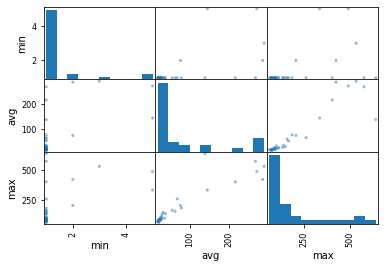

In [55]:
# 3: 除了 平行坐标图，管理员希望看到描述每个游乐项目的最小、平均和最大参入量的散点图矩阵，如上所述。


#分析： 使用平行坐标图的参入量数据绘制散点图矩阵
scatter_matrix(ride_attendance_wrapper_dict_frame)
plt.show()
